<a href="https://colab.research.google.com/github/firdowsacige/brain_tumor/blob/main/Dinov2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install segmentation-models-pytorch


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 14.5 MB/s eta 0:00:00


In [ ]:
!pip install opencv-python


In [ ]:
!pip install albumentations


In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
from torch.cuda.amp import GradScaler
from torch import autocast
from torch.utils.data import Dataset, DataLoader
from segmentation_models_pytorch.losses import DiceLoss

from torchmetrics import MetricCollection
from torchmetrics.aggregation import MeanMetric
from torchmetrics.classification import BinaryJaccardIndex, BinaryF1Score, BinaryRecall, BinaryPrecision, BinaryConfusionMatrix

#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [ ]:

!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=54b26069b37481eddbbae0594d622198194367d0664537dbcb795e32ff3dc464
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [ ]:
# Download the Kvasir-SEG dataset
import wget
import zipfile

In [ ]:
url = "http://datasets.simula.no/downloads/kvasir-seg.zip"
zip_path = "kvasir-seg.zip"
wget.download(url, zip_path)

'kvasir-seg.zip'

In [ ]:
# Extract the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/kvasir_seg")

In [62]:
import random
import numpy as np
import torch

SEED = 65
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [ ]:
ROOT_DIR = "/content"
DATA_DIR = "/content/kvasir_seg/Kvasir-SEG"
MODEL_DIR = os.path.join("/content", "models", "dinov2_linear_probing")
os.makedirs(MODEL_DIR, exist_ok=True) # creates the directory if it does not exist

IMAGE_FILES = os.path.join(DATA_DIR, "images/") # path to the images
MASK_FILES = os.path.join(DATA_DIR, "labels/") # path to the ground truth masks

print("Directories:")
print("Root directory:", ROOT_DIR)
print("Model directory:", MODEL_DIR)
print("Image files in directory:", IMAGE_FILES)
print("Ground Truth Mask files in directory:", MASK_FILES)

Directories:
Root directory: /content
Model directory: /content/models/dinov2_linear_probing
Image files in directory: /content/kvasir_seg/Kvasir-SEG/images/
Ground Truth Mask files in directory: /content/kvasir_seg/Kvasir-SEG/labels/


In [ ]:
IMAGE_SIZE = 224 # image size for the model input (H and W)
NORM_MEAN = (0.485, 0.456, 0.406) # mean values for normalization
NORM_STD = (0.229, 0.224, 0.225) # standard deviation values for normalization
class Polyp_Dataset(Dataset):
    """
    Custom PyTorch Dataset class for the polyp dataset that loads the images and masks and applies the albumentation augmentation pipeline.
    image_files: list of image filenames
    mask_files: list of mask filenames
    transform: albumentation augmentation pipeline
    """
    def __init__(self, image_files:list, mask_files:list , transform=None):
        self.image_files = image_files # list of image filenames
        self.mask_files = mask_files # list of mask filenames
        self.transform = transform # albumentation augmentation pipeline

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        img_file = self.image_files[index]
        mask_file = self.mask_files[index]

        # load image and mask files as numpy array using opencv
        img = cv2.cvtColor(cv2.imread(img_file, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)

        # Apply thresholding to make the mask binary (0 or 1)
        mask = (mask > 0).astype(np.int32)  # Convert any non-zero values to 1 (binary mask)

        # apply albumentation augmentation pipeline
        transformed = self.transform(image=img, mask=mask)
        img, mask = transformed['image'].float(), transformed['mask'].float()
        return (img, mask)


train_transform = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),  # Resize the image to the desired model input size
    A.HorizontalFlip(p=0.5),  # Flip the image horizontally with a probability of 0.5
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),  # Apply color jitter with a probability of 0.5
    A.Normalize(mean=NORM_MEAN, std=NORM_STD),  # Normalize the image
    ToTensorV2()  # Convert the image to a tensor
])

# albumentation pre-processing pipeline for the validation images
valid_transform = A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(mean=NORM_MEAN, std=NORM_STD),
        ToTensorV2(),
    ])

In [63]:
import glob
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader


IMAGE_FILES = "/content/kvasir_seg/Kvasir-SEG/images"
MASK_FILES = "/content/kvasir_seg/Kvasir-SEG/masks"

image_files = sorted(glob.glob(os.path.join(IMAGE_FILES, '*.jpg')))
mask_files = sorted(glob.glob(os.path.join(MASK_FILES, '*.jpg')))

# Print the total number of files found
print(f'Found {len(image_files)} images in total')
print(f'Found {len(mask_files)} masks in total')

# Ensure the number of images and masks match
assert len(image_files) == len(mask_files), "The number of images and masks must be the same."


SEED = 65

train_image_files, valid_image_files, train_mask_files, valid_mask_files = train_test_split(
    image_files, mask_files, test_size=0.2, random_state=SEED
)

# Print the number of files in each split
print(f'Found {len(train_image_files)} images for training')
print(f'Found {len(valid_image_files)} images for validation')

# Create the training and validation datasets
train_dataset = Polyp_Dataset(train_image_files, train_mask_files, train_transform)
valid_dataset = Polyp_Dataset(valid_image_files, valid_mask_files, valid_transform)

# Create the training and validation data loaders
BATCH_SIZE = 8

train_loader = DataLoader(dataset=train_dataset,
                          shuffle=True,  # Shuffles the data for training each epoch
                          batch_size=BATCH_SIZE,
                          num_workers=8,  # For multi-threaded data loading
                          pin_memory=True)

valid_loader = DataLoader(dataset=valid_dataset,
                          shuffle=False,  # Does not shuffle the data for validation
                          batch_size=BATCH_SIZE,
                          num_workers=8,  # For multi-threaded data loading
                          pin_memory=True)


Found 1000 images in total
Found 1000 masks in total
Found 800 images for training
Found 200 images for validation


In [64]:
dataiter = iter(train_loader) # get an iterator for the training data loader

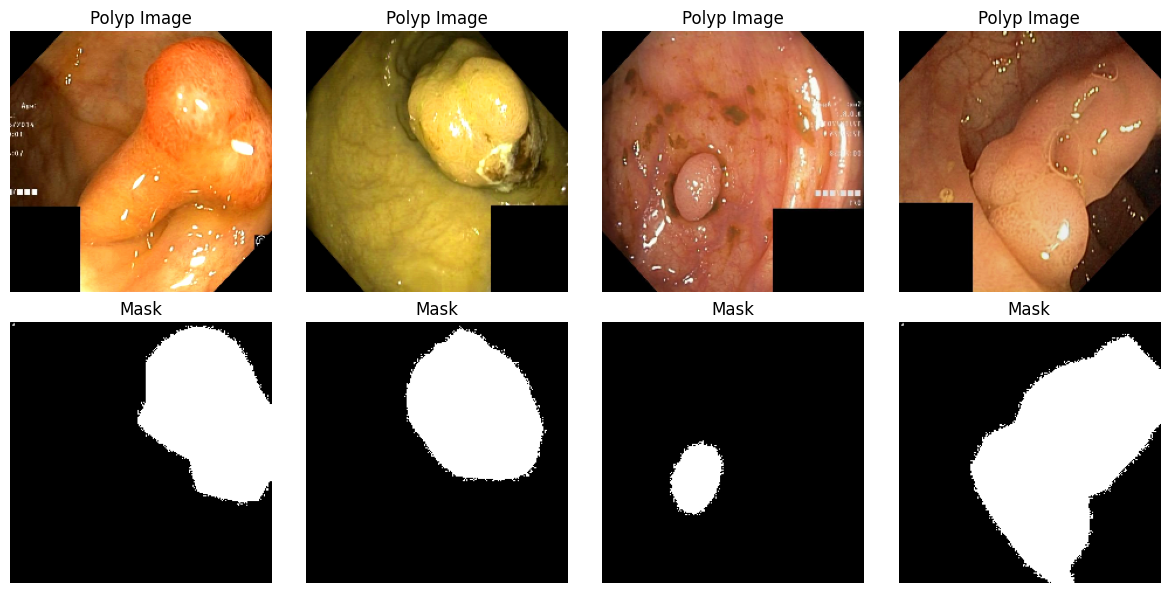

In [65]:
import matplotlib.colors as mcolors

def denormalization(img, mean=NORM_MEAN, std=NORM_STD):
    # denormalize pixel values of [-1,1] to [0,1]
    img = img * std + mean
    img = np.clip(img, 0, 1)
    return img
# Define a colormap: black for 0, white for 1
cmap = mcolors.ListedColormap(['black', 'white'])
def show_subset(images, masks, n):
    fig, ax = plt.subplots(2, n, figsize=(n*3,6))

    for i in range(n):
        ax[0, i].imshow(denormalization(np.rollaxis(images[i,:,:,:],0,3)), vmin=0, vmax=1)
        ax[1, i].imshow(masks[i,:,:], cmap=mcolors.ListedColormap(['black', 'white']), vmin=0, vmax=1)

        ax[0, i].set_title('Polyp Image')
        ax[1, i].set_title('Mask')
        ax[0, i].axis('off')
        ax[1, i].axis('off')

    plt.tight_layout()
    plt.show()

images, masks = next(dataiter) # get a batch of the training data loader
show_subset(images.numpy(), masks.numpy(), n=4) # show the first n images and masks of the batch

In [66]:
# defining the segmentation head
class SegHead(torch.nn.Module):
    """
    Segmentation head which transforms the low-dim feature map of the dinov2 backbone
    to a binary segmentation map and upsamples to the original image size.
    """
    def __init__(self, embed_dim, patch_size, none_linear_head=False, num_labels=1):
        super().__init__()
        self.embed_dim = embed_dim
        self.patch_size = patch_size

        self.classifier = torch.nn.Sequential(
            torch.nn.Conv2d(embed_dim, embed_dim // 4, kernel_size=1),
            torch.nn.SiLU(),
            torch.nn.Conv2d(embed_dim // 4, num_labels, kernel_size=1),
        ) if none_linear_head else torch.nn.Conv2d(embed_dim, num_labels, kernel_size=1)

        self.up = torch.nn.Upsample(scale_factor=patch_size, mode='bilinear', align_corners=False)

    def forward(self, embeddings):
        B, N, C = embeddings.shape

        # Infer patch map size (assumes square layout)
        H = W = int(N ** 0.5)
        if H * W != N:
            raise ValueError(f"Patch tokens ({N}) are not square. Cannot reshape to {H}x{W}.")

        embeddings = embeddings.reshape(B, H, W, C).permute(0, 3, 1, 2)  # [B, C, H, W]
        logits = self.classifier(embeddings)
        return self.up(logits)



# defining the model including the backbone and the segmentation head
class Model(torch.nn.Module):
    """
    Combines the DINOv2 backbone and the segmentation head.
    """
    def __init__(self, backbone, n_backbone_layers, none_linear_head, num_labels):
        super().__init__()
        self.backbone = backbone
        self.n_backbone_layers = n_backbone_layers

        self.classifier = SegHead(
            embed_dim=backbone.embed_dim * n_backbone_layers,
            patch_size=backbone.patch_size,
            none_linear_head=none_linear_head,
            num_labels=num_labels
        )

    def forward(self, images):
        outputs = self.backbone.get_intermediate_layers(images, n=self.n_backbone_layers, norm=True)
        outputs = torch.cat(outputs, dim=-1)  # concatenate layer embeddings
        logits = self.classifier(outputs)
        return logits



print("Creating model")
dinov2_backbone = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')

# Freeze backbone
for param in dinov2_backbone.parameters():
    param.requires_grad = False

model = Model(
    backbone=dinov2_backbone,
    n_backbone_layers=4,
    none_linear_head=True,
    num_labels=1
)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device, non_blocking=True)
print("Model ready on", device)


Creating model


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Model ready on cuda


In [67]:
# loss function
class ComboLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.dice = DiceLoss(mode='binary', from_logits=True)
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, logits, targets):
        return 0.7 * self.dice(logits, targets) + 0.3 * self.bce(logits, targets)

loss_function = DiceLoss(mode='binary', from_logits=True)

# optimizer
LEARN_RATE = 1e-04
optimizer = torch.optim.AdamW(filter(lambda param: param.requires_grad, model.parameters()), lr=LEARN_RATE)

scaler = GradScaler() # gradient scaler for mixed precision training

# metrics
loss_metric = MeanMetric().to(device)
metrics = MetricCollection({
    "dice": BinaryF1Score(threshold=0.5),
    'iou': BinaryJaccardIndex(threshold=0.5)
}).to(device)

# logs
logs = {'loss': [], 'iou': [], 'dice': [], 'val_loss': [], 'val_iou': [], 'val_dice': []}

<ipython-input-67-7ceb4e311f3b>:17: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() # gradient scaler for mixed precision training


In [68]:

NUM_EPOCHS = 40 # number of epochs to train


start_training = time.perf_counter() # start time of training

for epoch in range(NUM_EPOCHS):
    epoch_start = time.perf_counter() # start time of epoch
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}')

    ############################## train phase ####################################
    model.train() # set model to training mode
    optimizer.zero_grad(set_to_none=True) # zero the parameter gradients

    # iterate over training batches
    for (images, labels) in train_loader:
        images = images.to(device, non_blocking=True) # move images to device
        labels = labels.to(device, non_blocking=True).unsqueeze(dim=1) # move labels to device and add channel dimension

        # forward with mixed precision
        with autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(images)
            loss = loss_function(outputs, labels)

        scaler.scale(loss).backward() # backpropagate the loss
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # clip gradients to avoid exploding gradients
        scaler.step(optimizer) # update the model parameters
        scaler.update() # update the gradient scaler
        optimizer.zero_grad(set_to_none=True) # zero the parameter gradients


        # Computes training metrics for the batch
        loss_metric.update(loss.detach())
        preds = outputs.sigmoid().detach()
        metrics.update(preds, labels.int())


    # computes and reset metrics states
    epoch_loss = loss_metric.compute()
    epoch_metrics = metrics.compute()
    loss_metric.reset()
    metrics.reset()

    # appends results of training metrics to logs
    logs['loss'].append(epoch_loss.cpu().item())
    logs['dice'].append(epoch_metrics['dice'].cpu().item())
    logs['iou'].append(epoch_metrics['iou'].cpu().item())
    print(f"loss: {logs['loss'][epoch]:.5f}, dice: {logs['dice'][epoch]:.5f}, iou: {logs['iou'][epoch]:.5f}", end=' || ')


    optimizer.zero_grad(set_to_none=True)
    torch.cuda.empty_cache()

    ############################## valid phase ####################################
    with torch.no_grad():
        model.eval()

        # iterates over validation batches
        for (images, labels) in valid_loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True).unsqueeze(dim=1)

            # forwarsd with mixed precision
            with autocast(device_type='cuda', dtype=torch.float16):
                outputs = model(images)
                loss = loss_function(outputs, labels)

            # Computes metrics for the batch
            loss_metric.update(loss.detach())
            preds = outputs.sigmoid().detach()
            metrics.update(preds, labels.int())

        # computes and reset metrics states
        epoch_loss = loss_metric.compute()
        epoch_metrics = metrics.compute()
        loss_metric.reset()
        metrics.reset()

        # appends results of validation metrics to logs
        logs['val_loss'].append(epoch_loss.cpu().item())
        logs['val_dice'].append(epoch_metrics['dice'].cpu().item())
        logs['val_iou'].append(epoch_metrics['iou'].cpu().item())
        print(f"val_loss: {logs['val_loss'][epoch]:.5f}, val_dice: {logs['val_dice'][epoch]:.5f}, val_iou: {logs['val_iou'][epoch]:.5f}", end=' || ')

    # save logs as csv file
    logs_df = pd.DataFrame(logs)
    logs_df.to_csv(f'{MODEL_DIR}train_history.csv', index_label='epoch', sep=',', encoding='utf-8')

    # save model checkpoints every 10 epochs
    if (epoch % 10) == 0:
        torch.save(model.state_dict(), f'{MODEL_DIR}model_epoch{epoch}.pth')
        torch.save(optimizer.state_dict(), f'{MODEL_DIR}optimizer_epoch{epoch}.pth')
        torch.save(scaler.state_dict(), f'{MODEL_DIR}mp_scaler_epoch{epoch}.pth')

    epoch_end = time.perf_counter() # end time of epoch
    print(f"epoch runtime: {epoch_end-epoch_start:5.3f} sec.")
    torch.cuda.empty_cache()


# save the final model checkpoints
torch.save(model.state_dict(), f'{MODEL_DIR}model_epoch{epoch}.pth')
torch.save(optimizer.state_dict(), f'{MODEL_DIR}optimizer_epoch{epoch}.pth')
torch.save(scaler.state_dict(), f'{MODEL_DIR}mp_scaler_epoch{epoch}.pth')

end_training = time.perf_counter() # end time of trainig
print(f'Training succeeded in {(end_training - start_training):5.3f}s')

Epoch 1/40
loss: 0.21191, dice: 0.78489, iou: 0.64594 || val_loss: 0.17530, val_dice: 0.83298, val_iou: 0.71376 || epoch runtime: 19.954 sec.
Epoch 2/40
loss: 0.15542, dice: 0.85102, iou: 0.74068 || val_loss: 0.16332, val_dice: 0.84409, val_iou: 0.73023 || epoch runtime: 9.182 sec.
Epoch 3/40
loss: 0.14376, dice: 0.86297, iou: 0.75897 || val_loss: 0.15651, val_dice: 0.84895, val_iou: 0.73755 || epoch runtime: 9.135 sec.
Epoch 4/40
loss: 0.13711, dice: 0.86933, iou: 0.76887 || val_loss: 0.16037, val_dice: 0.84841, val_iou: 0.73673 || epoch runtime: 9.158 sec.
Epoch 5/40
loss: 0.13329, dice: 0.87388, iou: 0.77602 || val_loss: 0.15117, val_dice: 0.85486, val_iou: 0.74651 || epoch runtime: 9.139 sec.
Epoch 6/40
loss: 0.12973, dice: 0.87533, iou: 0.77831 || val_loss: 0.17622, val_dice: 0.83234, val_iou: 0.71282 || epoch runtime: 9.132 sec.
Epoch 7/40
loss: 0.12470, dice: 0.88183, iou: 0.78864 || val_loss: 0.14702, val_dice: 0.85841, val_iou: 0.75194 || epoch runtime: 9.185 sec.
Epoch 8/40
l

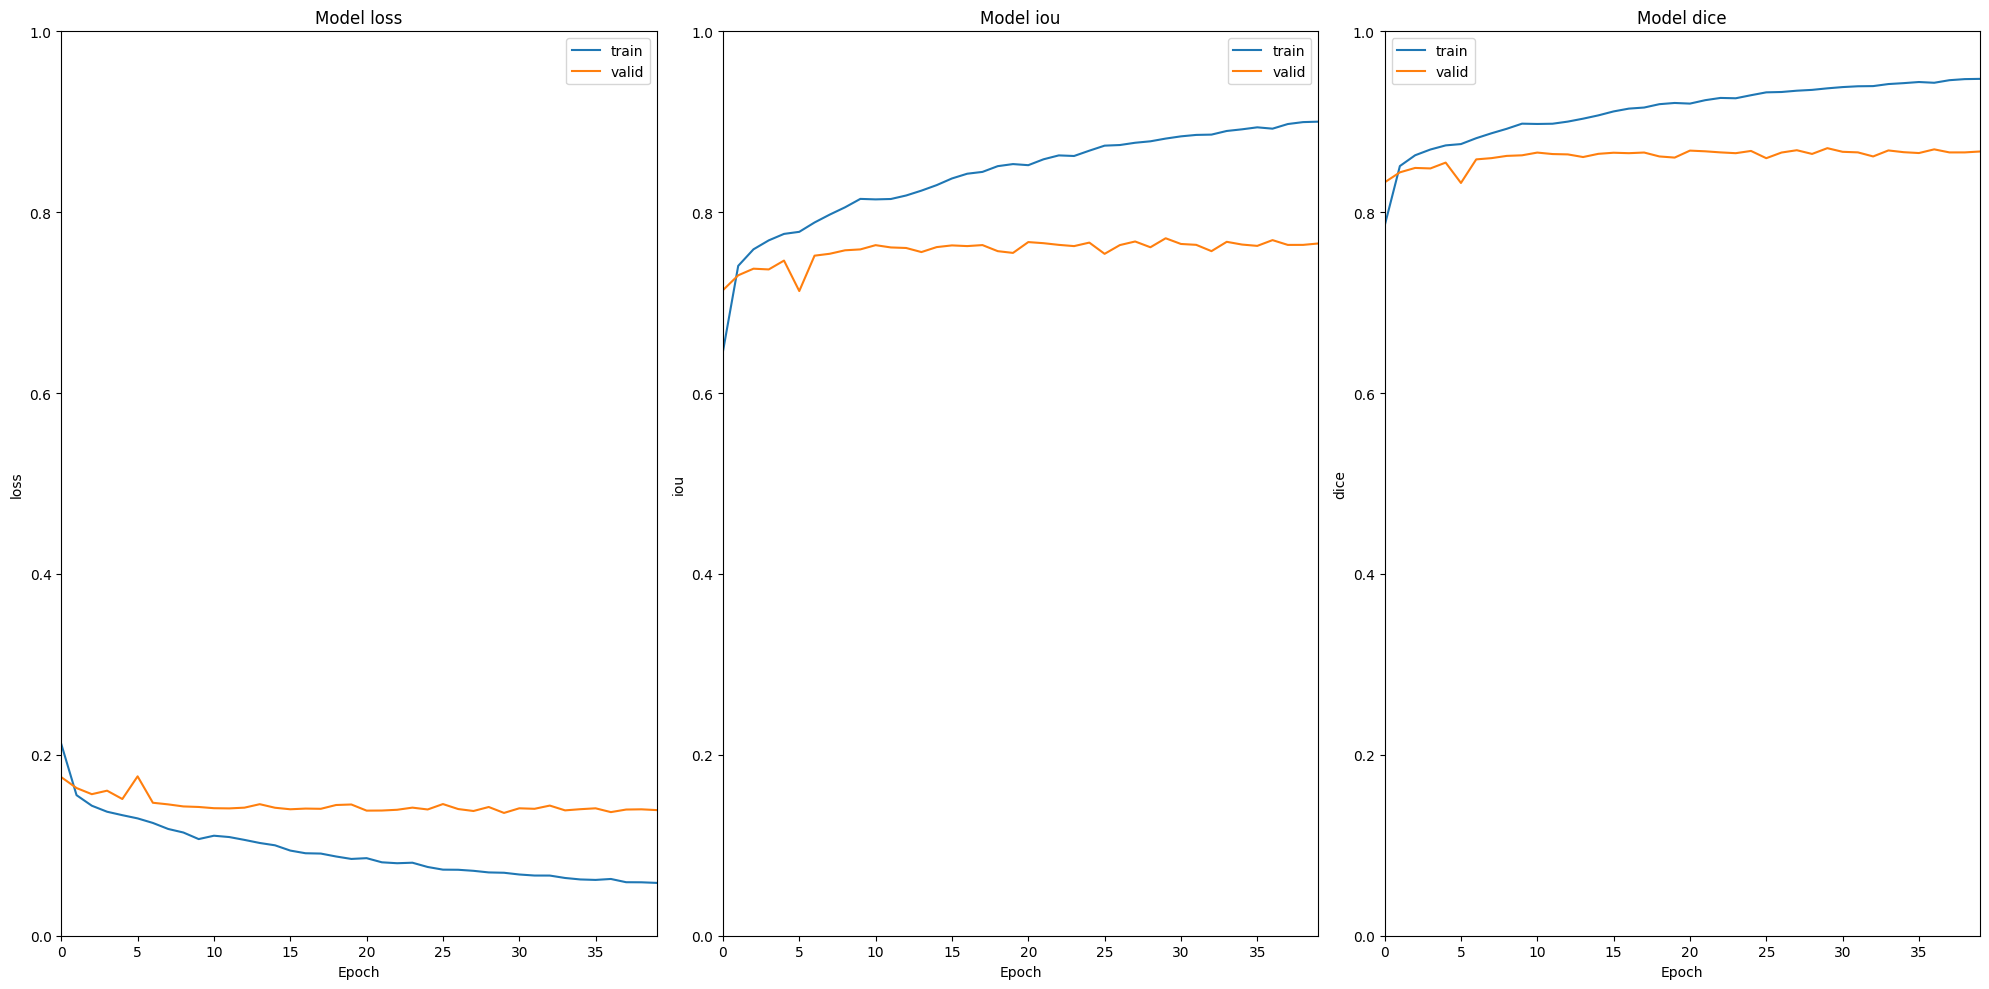

In [69]:
metrics_keys = ['loss', 'iou', 'dice']
fig, ax = plt.subplots(1, 3, figsize=(20, 10))

for i, metric in enumerate(metrics_keys):
    ax[i].plot(logs[metric], label='train')
    ax[i].plot(logs[f'val_{metric}'], label='valid')
    ax[i].set_title(f'Model {metric}')
    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(0, NUM_EPOCHS-1)
    ax[i].set_ylabel(metric)
    ax[i].set_xlabel('Epoch')
    ax[i].legend(loc='best')

fig.tight_layout()
fig.savefig(f'{MODEL_DIR}/training_history.png', dpi=100, format="png")
plt.show()

In [70]:
# final evaluation metrics
metrics = MetricCollection({
    "dice": BinaryF1Score(threshold=0.5),
    'iou': BinaryJaccardIndex(threshold=0.5),
    'recall': BinaryRecall(threshold=0.5),
    'precision': BinaryPrecision(threshold=0.5),
    'cm': BinaryConfusionMatrix(normalize=None, threshold=0.5)
})

# iterate over evaluation batches
with torch.no_grad():
    model.eval()
    for (images, masks) in tqdm(valid_loader):
        images, labels = images.to(device), masks.unsqueeze(dim=1).int() # transfer images to the GPU for model inference

        # model inference for each image in the batch
        with autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(images)

        prediction_probabilities = torch.sigmoid(outputs) # compute the model prediction probabilities from logits output
        prediction_masks = (prediction_probabilities > 0.5).int()

        # compute the evaluation metrics for the batch
        metrics.update(prediction_masks.cpu(), labels)


# compute the final evaluation metrics
eval_metrics = metrics.compute()
eval_metrics["fpv"] = eval_metrics['cm'][0,1] / (eval_metrics['cm'][0,1] + eval_metrics['cm'][0,0])
eval_metrics["fnv"] = eval_metrics['cm'][1,0] / (eval_metrics['cm'][1,0] + eval_metrics['cm'][1,1])
eval_metrics["ncm"] = eval_metrics["cm"] / torch.sum(eval_metrics["cm"], dim=1, keepdim=True)

# Print the metrics to the console
print(f"Testdata evaluation results:\n",
      f"IoU: {eval_metrics['iou']:.5f}\n",
      f"Dice: {eval_metrics['dice']:.5f}\n",
      f"Recall: {eval_metrics['recall']:.5f}\n",
      f"Precision: {eval_metrics['precision']:.5f}\n",
      f"FPE: {eval_metrics['fpv']:.5f}\n",
      f"FNE: {eval_metrics['fnv']:.5f}\n"
)

# Save the metrics as a JSON file
import json

# Function to convert tensors to standard Python data types
def convert_tensors(metrics_dict):
    converted_metrics = {}
    for key, value in metrics_dict.items():
        if isinstance(value, (np.ndarray, list, torch.Tensor)):
            converted_metrics[key] = value.tolist()
        elif hasattr(value, 'item'):  # for single-value tensors
            converted_metrics[key] = value.item()
        else:
            converted_metrics[key] = value
    return converted_metrics

converted_metrics = convert_tensors(eval_metrics)

with open(f'{MODEL_DIR}/eval_metrics.json', 'w') as f:
    json.dump(converted_metrics, f)

100%|██████████| 25/25 [00:03<00:00,  7.79it/s]

Testdata evaluation results:
 IoU: 0.76543
 Dice: 0.86713
 Recall: 0.84225
 Precision: 0.89353
 FPE: 0.01864
 FNE: 0.15775



confusion matrix:
[[8305696  157744]
 [ 247946 1323814]]
normalized confusion matrix:
[[0.9813617  0.01863828]
 [0.15775055 0.84224945]]


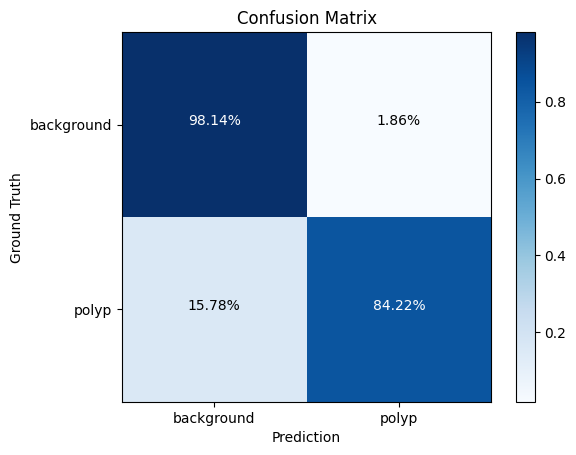

In [71]:
cm = eval_metrics['cm'].numpy()
ncm = eval_metrics['ncm'].numpy()
print(f"confusion matrix:\n{cm}\n"
     f"normalized confusion matrix:\n{ncm}")

# plot confusion matrix
fig, ax = plt.subplots(1,1)
cm_fig = ax.imshow(ncm, interpolation='nearest', cmap="Blues") # plot confusion matrix background color
fig.colorbar(cm_fig, ax=ax) # add confusion matrix color bar
ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))
ax.set_xticklabels(['background', 'polyp'])
ax.set_yticklabels(['background', 'polyp'])
ax.set_xlabel('Prediction')
ax.set_ylabel('Ground Truth')
ax.set_title("Confusion Matrix")

# plot confusion matrix values
for ix, iy in np.ndindex(ncm.shape):
    ax.text(iy, ix, f"{100*ncm[ix, iy]:.2f}%", horizontalalignment="center", color="white" if ncm[ix, iy] > ncm.max() / 2.0 else "black")

fig.savefig(f'{MODEL_DIR}/confusion_matrix.png', dpi=100, format="png")
plt.show()

In [72]:
def show_predictions(images, masks, prediction_masks, n=6):
    images = images.cpu().numpy()
    masks = masks.cpu().numpy()
    prediction_masks = prediction_masks.cpu().numpy()

    fig, ax = plt.subplots(3, n, figsize=(n*3,9))
    for i in range(n):
        ax[0, i].imshow(denormalization(np.rollaxis(images[i,:,:,:],0,3)), vmin=0, vmax=1, cmap='gray') # denormalize the image and convert to channel last format
        ax[1, i].imshow(masks[i,:,:], vmin=0, vmax=1, cmap='Blues_r')
        ax[2, i].imshow(prediction_masks[i,:,:], vmin=0, vmax=1, cmap='Blues_r')
        ax[0, i].set_title('Image')
        ax[1, i].set_title('polyp-Mask')
        ax[2, i].set_title('polyp Pred. Mask')
        ax[0, i].axis('off')
        ax[1, i].axis('off')
        ax[2, i].axis('off')
    plt.show()

dataiter = iter(valid_loader) # get iterator of validation data loader

In [73]:
def show_predictions(images, masks, prediction_masks, n=6):
    images = images.cpu().numpy()
    masks = masks.cpu().numpy()
    prediction_masks = prediction_masks.cpu().numpy()

    n = min(n, images.shape[0])  # Ensure we don't go out of bounds

    fig, ax = plt.subplots(3, n, figsize=(n * 3, 9))
    for i in range(n):
        ax[0, i].imshow(denormalization(np.rollaxis(images[i], 0, 3)), vmin=0, vmax=1, cmap='gray')
        ax[0, i].set_title('Image')

        ax[1, i].imshow(masks[i], vmin=0, vmax=1, cmap='gray')
        ax[1, i].set_title('Polyp Mask')

        ax[2, i].imshow(prediction_masks[i], vmin=0, vmax=1, cmap='gray')
        ax[2, i].set_title('Pred. Mask')

        ax[0, i].axis('off')
        ax[1, i].axis('off')
        ax[2, i].axis('off')

    plt.tight_layout()
    plt.show()


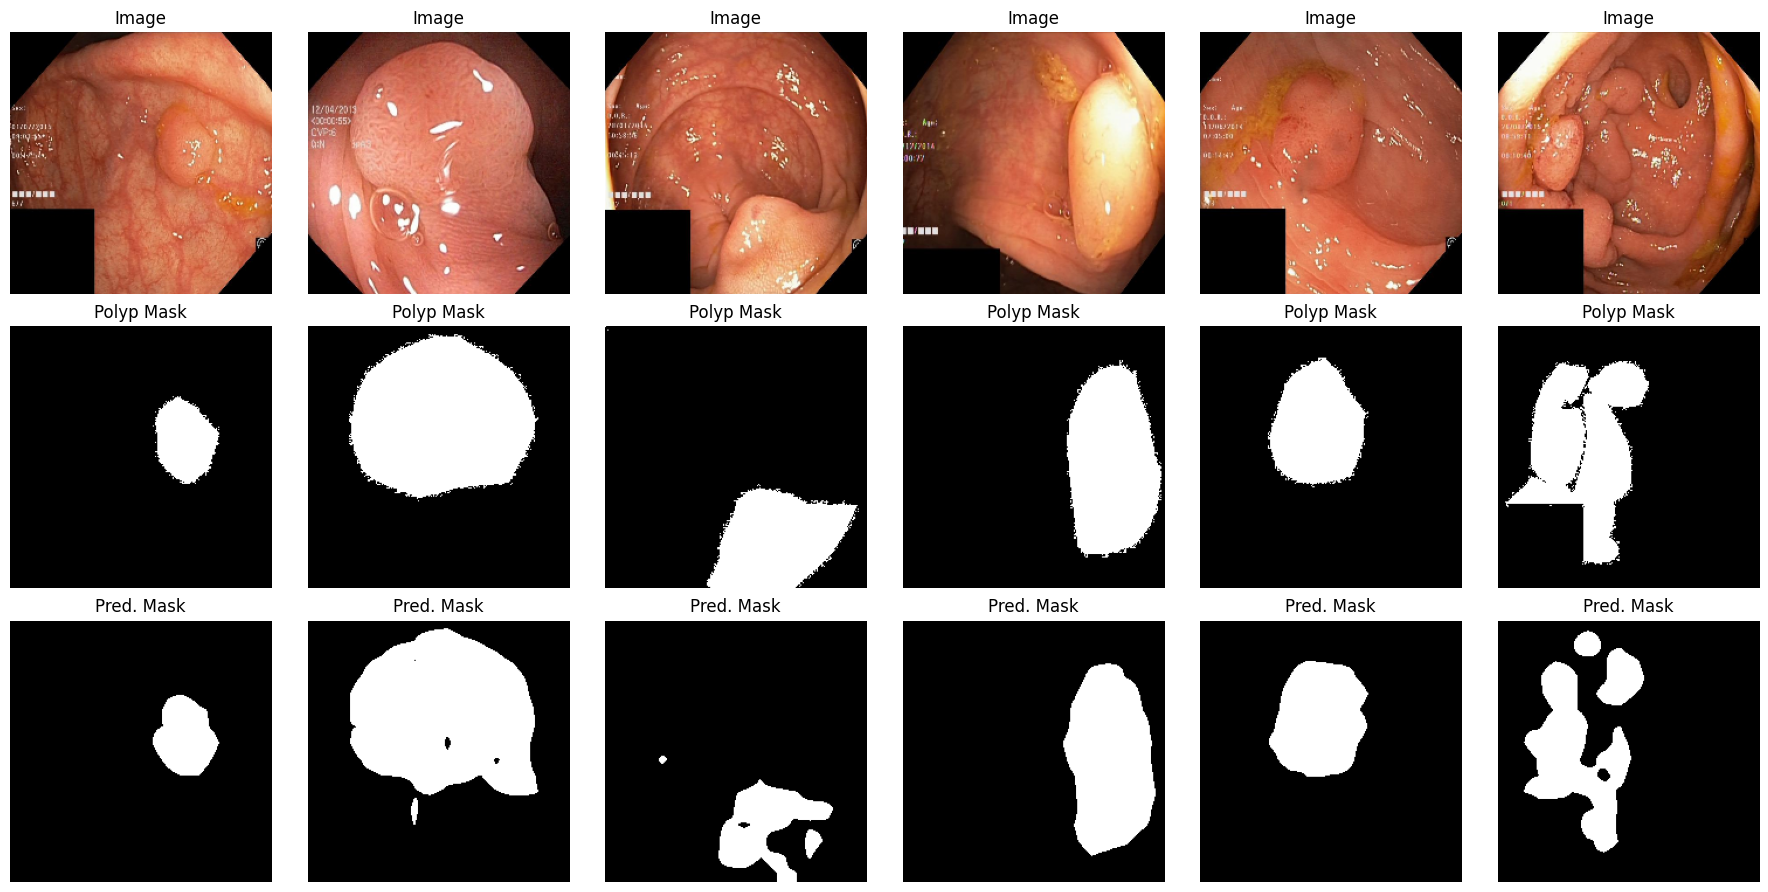

In [74]:
# Get a batch of validation data
dataiter = iter(valid_loader)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device).unsqueeze(dim=1)

# Get predictions
model.eval()
with torch.no_grad(), autocast(device_type='cuda', dtype=torch.float16):
    outputs = model(images)
    prediction_probs = torch.sigmoid(outputs)
    prediction_masks = (prediction_probs > 0.5).float()


labels = labels.squeeze(1)
prediction_masks = prediction_masks.squeeze(1)


show_predictions(images, labels, prediction_masks, n=6)
